In [1]:
# Copyright 2020 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<img src="http://developer.download.nvidia.com/compute/machine-learning/frameworks/nvidia_logo.png" style="width: 90px; float: right;">

## Overview

In the previous notebooks, we show how to preprocess a dataframe with single-hot categorical columns, and train a Tensorflow model with processed parquet files, and then to send request to Triton Inference Server. In this notebook, we deal with multi-hot categorical columns. To learn more about on multi-hot example with movielens dataset, you can visit the example notebooks under the [getting-started-movielens](https://github.com/NVIDIA/NVTabular/tree/main/examples/getting-started-movielens) folder.

### Learning Objectives

In this notebook, we show how to
- join two dataframes with JoinExternal operator
- preprocess single-hot categorical input features with NVTabular
- preprocess multi-hot categorical input features with NVTabular
- use LambdaOp for custom row-wise dataframe manipulations with NVTabular
- train a TF MLP model and save it on disk
- save the ensemble model to be used at the inference stage

## Getting Started

In [2]:
import os

import tensorflow as tf
from tensorflow.python.feature_column import feature_column_v2 as fc

# we can control how much memory to give tensorflow with this environment variable
# IMPORTANT: make sure you do this before you initialize TF's runtime, otherwise
# TF will have claimed all free GPU memory
os.environ['TF_MEMORY_ALLOCATION'] = "0.6" # fraction of free memory
from nvtabular.loader.tensorflow import KerasSequenceLoader, KerasSequenceValidater
from nvtabular.framework_utils.tensorflow import layers
from tensorflow.python.feature_column import feature_column_v2 as fc

In [3]:
# External dependencies
import cudf                 # cuDF is an implementation of Pandas-like Dataframe on GPU
import time
import gc

import nvtabular as nvt

from os import path
from sklearn.model_selection import train_test_split

We define our base directory, containing the data.

In [4]:
# path to store raw and preprocesses data
BASE_DIR = '/model/data/'

If the data is not available in the base directory, we will download and unzip the data.

In [5]:
if not path.exists(BASE_DIR + 'ml-25m'):
    if not path.exists(BASE_DIR + 'ml-25m.zip'):
        os.system("wget http://files.grouplens.org/datasets/movielens/ml-25m.zip")
        os.system("mv ml-25m.zip " + BASE_DIR)
    os.system("unzip " + BASE_DIR + "ml-25m.zip -d " + BASE_DIR)

## Preparing the dataset with NVTabular

First, we take a look on the movie metadata. 

We load the movies.

In [6]:
movies= cudf.read_csv(os.path.join(BASE_DIR, "ml-25m", "movies.csv"))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
movies['genres'] = movies['genres'].str.split('|')
movies = movies.drop('title', axis=1)
movies.head()

,movieId,genres
0,1,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,"[Adventure, Children, Fantasy]"
2,3,"[Comedy, Romance]"
3,4,"[Comedy, Drama, Romance]"
4,5,[Comedy]


We load the movie ratings.

In [8]:
ratings = cudf.read_csv(os.path.join(BASE_DIR, "ml-25m", "ratings.csv"))
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


We drop the timestamp column and split the ratings into training and test dataset. We use a simple random split.

In [9]:
ratings = ratings.drop('timestamp', axis=1)
train, valid = train_test_split(ratings, test_size=0.2, random_state=42)

In [10]:
train.to_parquet(BASE_DIR + 'train.parquet')
valid.to_parquet(BASE_DIR + 'valid.parquet')

Embedding Layers of neural networks require, that categorical features are continuous, incremental Integers: 0, 1, 2, ... , |C|-1. We need to ensure that our categorical features fulfill the requirement. We should transform the single-hot categorical features userId and movieId. NVTabular provides the operator `Categorify`, which provides this functionality with a high-level API out of the box.

Currently, our dataset consists of two separate dataframes. First, we use the JoinExternal operator to left-join the metadata (genres) to our rating dataset.

In [11]:
joined = (
    ['userId', 'movieId'] >> 
    nvt.ops.JoinExternal(movies, on=['movieId'])
)

Next, we will add Categorify for our categorical features (single hot: userId, movieId and multi-hot: genres).

In [12]:
cat_features = joined >> nvt.ops.Categorify(cat_cache="device")

The ratings are on a scale between 1-5. We want to predict a binary target with 1 are all ratings `>=4` and 0 are all ratings `<=3`. We use the [LambdaOp](https://github.com/NVIDIA/NVTabular/blob/main/nvtabular/ops/lambdaop.py) for it.

In [13]:
ratings = nvt.ColumnGroup(['rating']) >> (lambda col: (col>3).astype('int8'))

We can visualize our calculation graph.

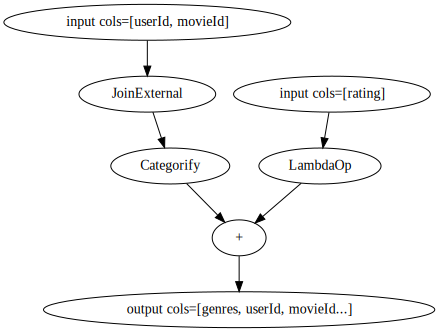

In [14]:
output = cat_features+ratings
(output).graph

We initialize our NVTabular `workflow`.

In [15]:
workflow = nvt.Workflow(output)

We save our train and valid datasets as parquet files on disk, and below we will read them in while initializing the Dataset objects.

In [16]:
del train
del valid
gc.collect()

51

We initialize NVTabular Datasets, and use the `part_size` parameter, which defines the size read into GPU-memory at once, in `nvt.Dataset`.

In [17]:
train_iter = nvt.Dataset(BASE_DIR + 'train.parquet', part_size='100MB')
valid_iter = nvt.Dataset(BASE_DIR + 'valid.parquet', part_size='100MB')

First, we collect the training dataset statistics.

In [18]:
%%time

workflow.fit(train_iter)

CPU times: user 1.51 s, sys: 844 ms, total: 2.35 s
Wall time: 4.16 s


We clear our output directories.

In [19]:
if path.exists(BASE_DIR + 'train'): 
    !rm -r $BASE_DIR/train
if path.exists(BASE_DIR + 'valid'): 
    !rm -r $BASE_DIR/valid

We transform our workflow with `.transform`.

In [20]:
%time

workflow.transform(train_iter).to_parquet(output_path=BASE_DIR + 'train/')
workflow.transform(valid_iter).to_parquet(output_path=BASE_DIR + 'valid/', shuffle=False)

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 15 µs


We can take a look in the output dir.

In [21]:
!ls $BASE_DIR/train

0.dcc642bed4734faa9cd94e077e94e127.parquet  _metadata
_file_list.txt				    _metadata.json


## TensorFlow: Training Neural Network

### Reviewing data

We can take a look on the data.

In [22]:
import glob

TRAIN_PATHS = sorted(glob.glob(BASE_DIR + 'train/*.parquet'))
VALID_PATHS = sorted(glob.glob(BASE_DIR + 'valid/*.parquet'))
TRAIN_PATHS, VALID_PATHS

(['/model/data/train/0.dcc642bed4734faa9cd94e077e94e127.parquet'],
 ['/model/data/valid/0.c875e8f08ad44e08aee3e1f5f4f7f5cf.parquet'])

We can see that our ratings are of only 0 and 1 after preprocessing.

In [23]:
df = cudf.read_parquet(TRAIN_PATHS[0])
df.head()

,genres,userId,movieId,rating
0,"[6, 9]",124027,11994,1
1,"[2, 17]",98809,2550,0
2,"[2, 3, 10, 17, 13]",81377,24262,1
3,"[3, 4, 5, 6, 10, 13]",116853,14786,1
4,"[5, 9, 10]",117118,1269,0


In [24]:
df.dtypes

genres      list
userId     int64
movieId    int64
rating      int8
dtype: object

In [25]:
del df
gc.collect()

147

At this step we are going to generate config.pbtxt and we will save our workflow as a .pkl file to be able to load again to do transformation for the test (new coming) datasets at inference stage. This step actually does the serialization of the workflow that we created above using the training set.

In [26]:
# converts a workflow to a triton mode 

from nvtabular.inference.triton import generate_nvtabular_model
generate_nvtabular_model(workflow, "movielens_nvt_mh", "/model/tf_models/movielens_nvt_mh/")

name: "movielens_nvt_mh"
input {
  name: "rating"
  data_type: TYPE_FP64
  dims: -1
  dims: 1
}
input {
  name: "userId"
  data_type: TYPE_INT64
  dims: -1
  dims: 1
}
input {
  name: "movieId"
  data_type: TYPE_INT64
  dims: -1
  dims: 1
}
output {
  name: "genres__values"
  data_type: TYPE_INT64
  dims: -1
  dims: 1
}
output {
  name: "genres__nnzs"
  data_type: TYPE_INT64
  dims: -1
  dims: 1
}
output {
  name: "userId"
  data_type: TYPE_INT64
  dims: -1
  dims: 1
}
output {
  name: "movieId"
  data_type: TYPE_INT64
  dims: -1
  dims: 1
}
output {
  name: "rating"
  data_type: TYPE_INT8
  dims: -1
  dims: 1
}
backend: "python"

Now we will train a TF MLP model using our preprocessed parquet files.

### Defining Hyperparameters

First, we define the data schema, and define our single-hot categorical features. Note, that we do not have any numerical input features. 

In [27]:
BATCH_SIZE = 1024*32                            # Batch Size
CATEGORICAL_COLUMNS = ['movieId', 'userId']     # Single-hot
CATEGORICAL_MH_COLUMNS = ['genres']             # Multi-hot
NUMERIC_COLUMNS = []

TRAIN_PATHS = sorted(glob.glob(BASE_DIR + 'train/*.parquet')) # Output from ETL-with-NVTabular
VALID_PATHS = sorted(glob.glob(BASE_DIR + 'valid/*.parquet')) # Output from ETL-with-NVTabular

We can get the embedding input and output dimensions.

In [41]:
EMBEDDING_TABLE_SHAPES = nvt.ops.get_embedding_sizes(workflow)
EMBEDDING_TABLE_SHAPES

{'genres': (21, 16), 'movieId': (56586, 512), 'userId': (162542, 512)}

We will use emb_dim 64 for `movieId` and `userId` categorical features.

In [28]:
EMBEDDING_TABLE_SHAPES = {'genres': (21, 16), 'movieId': (56586, 64), 'userId': (162542, 64)}

### Initializing NVTabular Data Loader for Tensorflow

The NVTabular data loader is initialized as usual and we specify both single-hot and multi-hot categorical features as cat_names. The data loader will automatically recognize the single/multi-hot columns and represent them accordingly.

In [29]:
train_dataset_tf = KerasSequenceLoader(
    TRAIN_PATHS, # you could also use a glob pattern
    batch_size=BATCH_SIZE,
    label_names=['rating'],
    cat_names=CATEGORICAL_COLUMNS+CATEGORICAL_MH_COLUMNS,
    cont_names=NUMERIC_COLUMNS,
    engine='parquet',
    shuffle=True,
    buffer_size=0.06, # how many batches to load at once
    parts_per_chunk=1
)

valid_dataset_tf = KerasSequenceLoader(
    VALID_PATHS, # you could also use a glob pattern
    batch_size=BATCH_SIZE,
    label_names=['rating'],
    cat_names = CATEGORICAL_COLUMNS+CATEGORICAL_MH_COLUMNS,
    cont_names=NUMERIC_COLUMNS,
    engine='parquet',
    shuffle=False,
    buffer_size=0.06,
    parts_per_chunk=1
)

### Defining Neural Network Architecture

We will define a common neural network architecture for tabular data.

- Single-hot categorical features are fed into an Embedding Layer
- Each value of a multi-hot categorical features is fed into an Embedding Layer and the multiple Embedding outputs are combined via averaging
- The output of the Embedding Layers are concatenated
- The concatenated layers are fed through multiple feed-forward layers (Dense Layers with ReLU activations)
- The final output is a single number with sigmoid activation function

First, we will define some dictonary/lists for our network architecture.

In [30]:
inputs = {}    # tf.keras.Input placeholders for each feature to be used
emb_layers = []# output of all embedding layers, which will be concatenated

We create `tf.keras.Input` tensors for all 4 input features.

In [31]:
for col in CATEGORICAL_COLUMNS:
    inputs[col] =  tf.keras.Input(
        name=col,
        dtype=tf.int64,
        shape=(1,)
    )
# Note that we need two input tensors for multi-hot categorical features
for col in CATEGORICAL_MH_COLUMNS:
    inputs[col+'__values'] = tf.keras.Input(
        name=f"{col}__values", 
        dtype=tf.int64, 
        shape=(1,)
    )
    inputs[col+'__nnzs'] = tf.keras.Input(
        name=f"{col}__nnzs", 
        dtype=tf.int64, 
        shape=(1,)
    )

Next, we initialize Embedding Layers with `tf.feature_column.embedding_column`.

In [32]:
for col in CATEGORICAL_COLUMNS+CATEGORICAL_MH_COLUMNS:
    emb_layers.append(
        tf.feature_column.embedding_column(
            tf.feature_column.categorical_column_with_identity(
                col, 
                EMBEDDING_TABLE_SHAPES[col][0]                    # Input dimension (vocab size)
            ), EMBEDDING_TABLE_SHAPES[col][1]                     # Embedding output dimension
        )
    )
emb_layers

[EmbeddingColumn(categorical_column=IdentityCategoricalColumn(key='movieId', number_buckets=56586, default_value=None), dimension=64, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7fcd21765af0>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True, use_safe_embedding_lookup=True),
 EmbeddingColumn(categorical_column=IdentityCategoricalColumn(key='userId', number_buckets=162542, default_value=None), dimension=64, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7fcd217651c0>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True, use_safe_embedding_lookup=True),
 EmbeddingColumn(categorical_column=IdentityCategoricalColumn(key='genres', number_buckets=21, default_value=None), dimension=16, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7fcd217652b0>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=Non

NVTabular implemented a custom TensorFlow layer `layers.DenseFeatures`, which takes as an input the different `tf.Keras.Input` and pre-initialized `tf.feature_column` and automatically concatenates them into a flat tensor. `DenseFeatures` can handle numeric inputs, as well, but MovieLens does not provide numerical input features.

In [33]:
emb_layer = layers.DenseFeatures(emb_layers)
x_emb_output = emb_layer(inputs)
x_emb_output

<KerasTensor: shape=(None, 144) dtype=float32 (created by layer 'dense_features')>

We can see that the output shape of the concatenated layer is equal to the sum of the individual Embedding output dimensions.


We add multiple Dense Layers. Finally, we initialize the `tf.keras.Model` and add the optimizer.

In [34]:
x = tf.keras.layers.Dense(128, activation='relu')(x_emb_output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.compile('sgd', 'binary_crossentropy')

### Training the deep learning model

We can train our model with `model.fit`.

In [35]:
validation_callback = KerasSequenceValidater(valid_dataset_tf)

history = model.fit(train_dataset_tf, callbacks=[validation_callback], epochs=3)

Epoch 1/3
611/611 [==============================] - 17s 26ms/step - loss: 0.6749
Epoch 2/3
611/611 [==============================] - 15s 25ms/step - loss: 0.6602
Epoch 3/3
611/611 [==============================] - 15s 25ms/step - loss: 0.6591


We can save the trained TF model

In [36]:
model.save('/model/tf_models/movielens_tf_mh/1/model.savedmodel')

INFO:tensorflow:Assets written to: /model/tf_models/movielens_tf_mh/1/model.savedmodel/assets


In [37]:
# Creates an ensemble triton server model, where
#   model: The tensorflow model that should be served
#   workflow: The nvtabular workflow used in preprocessing
#   name: The base name of the various triton models

from nvtabular.inference.triton import export_tensorflow_ensemble
export_tensorflow_ensemble(model, workflow, "movielens_mh", "/model/models_multihot/", ["rating"])

INFO:tensorflow:Assets written to: /model/models_multihot/movielens_mh_tf/1/model.savedmodel/assets


In [38]:
#!apt-get install tree

Each model in a model repository must include a model configuration that provides required and optional information about the model. Next, Triton needs a config file to understand how to interpret the model.

In [39]:
!tree /model/models_multihot/

/model/models_multihot/
├── movielens_mh
│   ├── 1
│   └── config.pbtxt
├── movielens_mh_nvt
│   ├── 1
│   │   ├── model.py
│   │   └── workflow
│   │       ├── categories
│   │       │   ├── unique.genres.parquet
│   │       │   ├── unique.movieId.parquet
│   │       │   └── unique.userId.parquet
│   │       ├── metadata.json
│   │       └── workflow.pkl
│   └── config.pbtxt
└── movielens_mh_tf
    ├── 1
    │   └── model.savedmodel
    │       ├── assets
    │       ├── saved_model.pb
    │       └── variables
    │           ├── variables.data-00000-of-00001
    │           └── variables.index
    └── config.pbtxt

11 directories, 12 files


We will move to the next notebook, [movielens-multihot-inference](), to send request to the Triton Inference Server.